# Soils

### Feng Yin
### Department of Geography, UCL
### ucfafyi@ucl.ac.uk


In this notebook, I will introduce the process of gathering soil spectra from multiple sources and interpolating them into same wavelength range (400-2500). Then the principal component analysis (PCA) is applied to derive a handful of PCs for later usage.

There is not a lot of soil spectra from a single source, and we want to have samples to cover major type of soils around the world, so we end up collecting all the available soil spectra (I can find on the internet) from different sources. Below is the list of sources:

1. [USGS spectral library](https://www.usgs.gov/energy-and-minerals/mineral-resources-program/science/usgs-high-resolution-spectral-library), V5, V6 and V7;
2. [ICRAF-ISRIC Soil VNIR Spectral Library](https://www.isric.org/explore/ISRIC-collections);
3. [Prosail soil model](https://github.com/jgomezdans/prosail/blob/master/prosail/soil_reflectance.txt);
4. [Price soil model](https://naldc.nal.usda.gov/download/37764/PDF)
5. North China plain (NCP) in-situ measurements.

So in the following processing steps, I will try to generate samples from those soil models and interpolating them to the same wavelength invertal.

In [108]:
import numpy as np
import pandas as pd
import pylab as plt
from glob import glob
import gp_emulator
%matplotlib inline

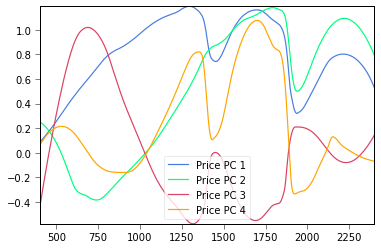

In [109]:
pricePCs = np.loadtxt('PriceACRM.txt')
plt.plot(pricePCs [:,0], pricePCs [:, 1], label = 'Price PC 1')
plt.plot(pricePCs [:,0], pricePCs [:, 2], label = 'Price PC 2')
plt.plot(pricePCs [:,0], pricePCs [:, 3], label = 'Price PC 3')
plt.plot(pricePCs [:,0], pricePCs [:, 4], label = 'Price PC 4')
plt.legend()

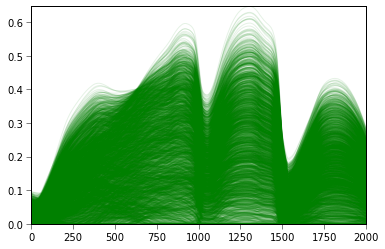

In [128]:
parameters = ['w1', 'w2','w3', 'w4']
# This range of weights are from the original (Price, 1990) paper
# but divided by 100, as the reflectance in (Price, 1990) paper
# is described by %
p_mins = [   0, -0.10, -0.10, -0.04]
p_maxs = [ 0.4,  0.10,  0.10,  0.04]
num_samp = 3000
sample, distributions = gp_emulator.create_training_set(parameters, p_mins, p_maxs, n_train=num_samp)
price_soil = sample.dot(pricePCs[:, 1:].T)
price_soil[price_soil<0] = 0  # Follwoing ACRM
h = plt.plot(price_soil.T, 'g-', lw=1, alpha=0.1)